In [71]:
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from scipy import stats, special
from sentence_transformers import SentenceTransformer, util, CrossEncoder
from tqdm import tqdm
from ast import literal_eval
# from numba import njit


DATA_DIR_PATH = "../../project_data/"

### 1. Считываем данные

In [99]:
# data = pd.read_csv(DATA_DIR_PATH + 'assessors_test_l_q_u_t_m_b_ql.tsv', sep='\t', nrows=300000)

In [4]:
f = open(DATA_DIR_PATH + 'sample_1500.json')

# data = pd.read_csv(DATA_DIR_PATH + 'sample_1500.tsv', sep="\t")
data = json.load(f)

In [61]:
df_processed = pd.DataFrame.from_dict(data[:1000])

In [62]:
df_processed.head()

,query,label,body
0,нужна ли в школе школьная форма,"[1, 1, 1, 1, 3, 1, 2, 1, 3, 2, 3, 1, 1, 2, 1, ...",[Дніпрорудненська спеціалізована школа І-ІІІ с...
1,с какой целью на ваш взгляд император настойчи...,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...",[Вход Запомнить Регистрация Задать вопрос Исто...
2,79843336490 звонят,"[2, 2]",[178775 Телефонные мошенники 54539 Назойливые ...
3,чем ухаживать за стальными ваннами,"[2, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 2, ...","[Зайти , Стальные и чугунные ванны → Как ухажи..."
4,рыбников звёздный мальчик музыка скачать,"[1, 1, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1, 3, ...",[Фрагмент из Фильма СКАЗКА О ЗВЁЗДНОМ МАЛЬЧИКЕ...


In [63]:
df_processed_exp = df_processed.explode(["label", "body"])

In [64]:
df_processed_exp.dropna(inplace=True)
df_processed_2 = df_processed_exp.groupby('query').agg(lambda x: list(x)).reset_index()

In [65]:
df_processed_2.head()

,query,label,body
0,1 вычислите синус 7п 3,"[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...",[Главная Карта Узнать ещё Знание — сила. Позна...
1,1 противоправное действие 2 общественно опасно...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, ...",[Правонарушением признается деяния лишь деликт...
2,11 04 2020 березовский,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",[Вкл/выкл навигации КГБУСО «Березовский» Главн...
3,21829051 р р рјрїрµсђ рірѕр сњрірѕ рєсѓрїрёс с...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Р“Р›РђР’Рђ 8 2 page ⇐ Предыдущая Стр 42 из 44...
4,222dafk 123torrent org search вампирелл,"[1, 1, 1, 1, 1, 1, 1, 1]",[Вход Регистрация superheroes.ru superheroes.r...


In [66]:
df_processed_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   1000 non-null   object
 1   label   1000 non-null   object
 2   body    1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [67]:
count_rel = []
for row in df_processed_2.iterrows():
    labels = row[1]["label"]
    labels_np = np.array(labels)
    count_rel.append(np.array(labels_np > 1, dtype=int).sum())

In [68]:
count_rel

[9,
 37,
 1,
 0,
 0,
 0,
 6,
 33,
 2,
 1,
 6,
 27,
 5,
 3,
 2,
 9,
 10,
 1,
 7,
 20,
 2,
 27,
 9,
 1,
 27,
 21,
 2,
 3,
 5,
 33,
 8,
 20,
 18,
 18,
 3,
 6,
 13,
 1,
 19,
 25,
 7,
 13,
 17,
 2,
 25,
 5,
 3,
 7,
 1,
 6,
 15,
 4,
 8,
 12,
 2,
 3,
 0,
 2,
 2,
 2,
 2,
 4,
 10,
 5,
 10,
 6,
 30,
 18,
 3,
 6,
 8,
 18,
 0,
 18,
 5,
 11,
 6,
 5,
 0,
 2,
 32,
 8,
 26,
 3,
 9,
 1,
 4,
 4,
 14,
 20,
 7,
 11,
 8,
 1,
 3,
 5,
 12,
 1,
 7,
 21,
 21,
 13,
 20,
 9,
 2,
 3,
 9,
 26,
 2,
 12,
 7,
 15,
 8,
 18,
 34,
 10,
 7,
 40,
 1,
 6,
 2,
 9,
 23,
 33,
 3,
 18,
 7,
 34,
 1,
 3,
 4,
 4,
 8,
 10,
 36,
 28,
 21,
 3,
 15,
 20,
 4,
 14,
 27,
 13,
 4,
 1,
 0,
 8,
 37,
 8,
 12,
 2,
 41,
 12,
 17,
 3,
 9,
 23,
 5,
 28,
 1,
 10,
 1,
 29,
 2,
 6,
 5,
 32,
 18,
 13,
 0,
 2,
 43,
 32,
 4,
 26,
 9,
 5,
 12,
 12,
 11,
 9,
 12,
 9,
 2,
 29,
 14,
 17,
 7,
 20,
 17,
 20,
 1,
 7,
 6,
 6,
 13,
 10,
 15,
 14,
 6,
 13,
 30,
 0,
 2,
 6,
 3,
 13,
 12,
 17,
 25,
 25,
 10,
 10,
 1,
 13,
 12,
 24,
 24,
 36,
 26,
 11,
 15,
 19,


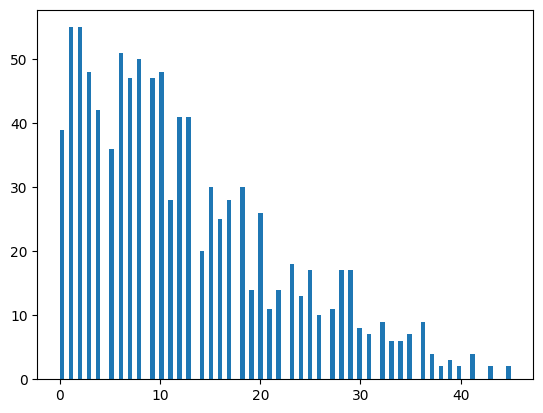

In [74]:
plt.hist(count_rel, bins=100)
plt.show()

In [3]:
# column_names = ["label", "query", "url", "title", "meta", "body", "qlinks"]
# data.columns = column_names
# data.dropna(subset="body", inplace=True)
# data.drop(["url", "title", "meta", "qlinks"], axis=1, inplace=True)

In [4]:
# data.head()

,label,query,body
0,3,0 00 дом muzono net raim feat artur adil скачать,RaiM feat. Artur & Adil - Дом 2018 Исполнитель...
1,2,0 00 дом muzono net raim feat artur adil скачать,﻿ / RaiM ft. Artur & Adil - Дом RaiM ft. Artur...
2,2,0 00 дом muzono net raim feat artur adil скачать,» RaiM feat. Artur & Adil - Дом RaiM feat. Art...
3,2,0 00 дом muzono net raim feat artur adil скачать,» RaiM feat. Artur & Adil - Дом 2018 RaiM feat...
4,3,0 00 дом muzono net raim feat artur adil скачать,» RaiM feat. Artur & Adil - Дом 2018 RaiM feat...


In [89]:
# выгрузим данные для коллаба
# data.to_csv(DATA_DIR_PATH + 'data_for_rk_model.tsv', sep="\t")

### 2. Преобразуем данные нужным образом

In [5]:
# df_processed = data.groupby('query').agg(lambda x: list(x)).reset_index()

In [6]:
# df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5470 entries, 0 to 5469
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   query   5470 non-null   object
 1   label   5470 non-null   object
 2   body    5470 non-null   object
dtypes: object(3)
memory usage: 128.3+ KB


In [122]:
# df_processed = data[:5]

In [126]:
# df_processed = pd.DataFrame.from_dict(data[:5])

In [128]:
# df_processed.head()

,query,label,body
0,нужна ли в школе школьная форма,"[1, 1, 1, 1, 3, 1, 2, 1, 3, 2, 3, 1, 1, 2, 1, ...",[Дніпрорудненська спеціалізована школа І-ІІІ с...
1,с какой целью на ваш взгляд император настойчи...,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...",[Вход Запомнить Регистрация Задать вопрос Исто...
2,79843336490 звонят,"[2, 2]",[178775 Телефонные мошенники 54539 Назойливые ...
3,чем ухаживать за стальными ваннами,"[2, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 2, ...","[Зайти , Стальные и чугунные ванны → Как ухажи..."
4,рыбников звёздный мальчик музыка скачать,"[1, 1, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1, 3, ...",[Фрагмент из Фильма СКАЗКА О ЗВЁЗДНОМ МАЛЬЧИКЕ...


In [76]:
def tokenaizer(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]

    tokenized_sentences = []
    for cur_sent in sentences:
        tokenized_sentences.append(cur_sent.split(" "))
    return tokenized_sentences


def ratings_v1(data, model_name):
    df_tmp = data[["query", "label", "body"]].copy()
    la_bse = SentenceTransformer('sentence-transformers/LaBSE')
    ms_marco_st = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    ms_marco_ce = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', max_length=512)
    
    sorted_scores = []
    true_scores = []
    
    clear_scores = []
    
    for row in tqdm(data.iterrows()):
        query = row[1]["query"]
        sentences = row[1]["body"]

        if model_name == "bm_25":
            tokenized_query = tokenaizer(row[1]["query"])[0]
            tokenized_sentences = tokenaizer(row[1]["body"])
            bm25 = BM25Okapi(tokenized_sentences)
            scores = np.array(bm25.get_scores(tokenized_query))
            
        if model_name == "la_bse":
            query = la_bse.encode(query)
            embeddings = la_bse.encode(sentences)
            scores = util.pytorch_cos_sim(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_st":
            query = ms_marco_st.encode(query)
            embeddings = ms_marco_st.encode(sentences)
            scores = util.dot_score(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_ce":
            pairs_que_sent = []
            for sent in sentences:
                pairs_que_sent.append((query, sent))
            scores = ms_marco_ce.predict(pairs_que_sent)
            
        sorted_scores.append(-np.sort(-scores))
        
        clear_scores.append(scores)

        tmp_2d_list = []
        for item in zip(row[1]["label"], scores):
            tmp_2d_list.append([item[0], item[1]])
        tmp_2d_list.sort(key=lambda x: (x[0], x[1]), reverse=True)
        true_scores.append(np.array(tmp_2d_list).T[1])

    df_tmp[f"sorted_scores__{model_name}"] = sorted_scores
    df_tmp[f"true_scores__{model_name}"] = true_scores
    df_tmp[f"clear_scores__{model_name}"] = clear_scores

    return df_tmp
            

def ratings_v2(data, model_name):
    df_tmp = data[["query", "label", "body"]].copy()
    la_bse = SentenceTransformer('sentence-transformers/LaBSE')
    ms_marco_st = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    ms_marco_ce = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', max_length=512)
    
    sorted_labels = []
    model_labels = []
    
    clear_scores = []
    
    for row in tqdm(data.iterrows()):
        query = row[1]["query"]
        sentences = row[1]["body"]

        if model_name == "bm_25":
            tokenized_query = tokenaizer(row[1]["query"])[0]
            tokenized_sentences = tokenaizer(row[1]["body"])
            bm25 = BM25Okapi(tokenized_sentences)
            scores = np.array(bm25.get_scores(tokenized_query))
            
        if model_name == "la_bse":
            query = la_bse.encode(query)
            embeddings = la_bse.encode(sentences)
            scores = util.pytorch_cos_sim(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_st":
            query = ms_marco_st.encode(query)
            embeddings = ms_marco_st.encode(sentences)
            scores = util.dot_score(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_ce":
            pairs_que_sent = []
            for sent in sentences:
                pairs_que_sent.append((query, sent))
            scores = ms_marco_ce.predict(pairs_que_sent)
        
        sorted_labels.append(-np.sort(-np.array(row[1]["label"])))
        
        clear_scores.append(scores)
        
        tmp_2d_list = []
        for item in zip(row[1]["label"], scores):
            tmp_2d_list.append([item[0], item[1]])
        tmp_2d_list.sort(key=lambda x: x[1], reverse=True)
        model_labels.append(np.array(tmp_2d_list, dtype=int).T[0])

    df_tmp[f"sorted_labels__{model_name}"] = sorted_labels
    df_tmp[f"model_labels__{model_name}"] = model_labels
    df_tmp[f"clear_scores__{model_name}"] = clear_scores

    return df_tmp    


def count_relevant(labels_array):
    labels_np = np.array(labels_array)
    return np.array(labels_np > 1, dtype=int).sum()


def top_n_rel(data, model_name, top_n):
    df_tmp = data[["query", "label", "body"]].copy()
    la_bse = SentenceTransformer('sentence-transformers/LaBSE')
    ms_marco_st = SentenceTransformer('sentence-transformers/msmarco-bert-base-dot-v5')
    ms_marco_ce = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', max_length=512)
    
#     sorted_labels = []
    FORDIT = []
    model_labels = []
    
    clear_scores = []
    
    for row in tqdm(data.iterrows()):
        query = row[1]["query"]
        sentences = row[1]["body"]

        if model_name == "bm_25":
            tokenized_query = tokenaizer(row[1]["query"])[0]
            tokenized_sentences = tokenaizer(row[1]["body"])
            bm25 = BM25Okapi(tokenized_sentences)
            scores = np.array(bm25.get_scores(tokenized_query))
            
        if model_name == "la_bse":
            query = la_bse.encode(query)
            embeddings = la_bse.encode(sentences)
            scores = util.pytorch_cos_sim(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_st":
            query = ms_marco_st.encode(query)
            embeddings = ms_marco_st.encode(sentences)
            scores = util.dot_score(query, embeddings).numpy()[0]
            
        if model_name == "ms_marco_ce":
            pairs_que_sent = []
            for sent in sentences:
                pairs_que_sent.append((query, sent))
            scores = ms_marco_ce.predict(pairs_que_sent)
        
#         sorted_labels.append(-np.sort(-np.array(row[1]["label"])))
        
        clear_scores.append(scores)
        
        tmp_2d_list = []
        for item in zip(row[1]["label"], scores):
            tmp_2d_list.append([item[0], item[1]])
        tmp_2d_list.sort(key=lambda x: x[1], reverse=True)
        model_labels_tmp = np.array(tmp_2d_list, dtype=int).T[0]
        model_labels.append(model_labels_tmp)
        
        real_rel_number = count_relevant(row[1]["label"])
        if real_rel_number > 0:
            min_rel_number = min(real_rel_number, top_n)
            top_n_labels = model_labels_tmp[:min_rel_number]
            FORDIT.append(count_relevant(top_n_labels) / min_rel_number)  # fraction of relevant docs in top n
        else:
            top_n_labels = []
            FORDIT.append(np.nan)
        
        
        print(row[1]["label"])
        print(model_labels[-1])
        print(np.array(tmp_2d_list, dtype=float).T[1])
        print(real_rel_number)
        print(top_n_labels)
        print(FORDIT[-1])
        print()
        

#     df_tmp[f"sorted_labels__{model_name}"] = sorted_labels
    df_tmp[f"model_labels__{model_name}"] = model_labels
    df_tmp[f"clear_scores__{model_name}"] = clear_scores
    df_tmp[f"FORDIT__{model_name}"] = FORDIT

    return df_tmp        
    
    
def count_metrics(df, col_1_name, col_2_name):
    k_corr_coeffs = []
    s_corr_coeffs = []
    
    for i, row in enumerate(df.iterrows()):
        kendal_corr = stats.kendalltau(row[1][col_1_name], row[1][col_2_name]).correlation
        if not np.isnan(kendal_corr):
            k_corr_coeffs.append(kendal_corr)
            
        spearman_corr = stats.spearmanr(row[1][col_1_name], row[1][col_2_name]).correlation
        if not np.isnan(spearman_corr):
            s_corr_coeffs.append(spearman_corr)
    
    model_name = col_2_name.split("__")[1]
    
    print(f"Kendall corr coeff on {model_name} = {np.round(np.mean(k_corr_coeffs), 4)}")
    print(f"Spearman corr coeff on {model_name} = {np.round(np.mean(s_corr_coeffs), 4)}")

In [77]:
a = np.array([2, 3, 1, 0, 0, 3, 2, 0, 2])
np.array(a > 1, dtype=int).sum()

5

In [21]:
2/5

0.4

In [85]:
models = ["bm_25"]

for model_name in models:
    df_processed_2 = top_n_rel(df_processed_2[:15], model_name, top_n=10)
    
#     count_metrics(df_processed_2, f"sorted_scores__{model_name}", f"true_scores__{model_name}")
#     count_metrics(df_processed_2, "label", f"clear_scores__{model_name}")

15it [00:00, 69.22it/s]

[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2]
[2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 3 1 3 2 1 3 1 1 1 1 1]
[4.29613    3.91034965 3.34668114 3.14158918 3.13997715 3.0304222
 2.94955513 2.74519119 2.4591152  2.43139768 2.31963813 2.28143043
 2.08950693 2.07252648 2.04212391 1.85923014 1.83496896 1.49651023
 1.37128977 1.22411759 1.19346471 1.18260481 1.11568177 1.01680523
 0.62535142 0.         0.         0.         0.        ]
9
[2 1 1 1 1 1 1 2 1]
0.2222222222222222

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
[2 2 2 2 2 2 0 2 2 2 2 0 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3]
[16.76557041 15.04029789 14.55216115 14.54077608 13.55444137 13.48919935
 13.00284071 12.82755667 12.44138829 11.95958333 11.29872761 10.850158
 10.7482643  10.15491995  9.64198509  9.64099898  9.53082897  8.89252604
  8.77495826  8.60332877  8.55039412  8.43062076  8.40380047

In [86]:
df_processed_2.head()

,query,label,body,model_labels__bm_25,clear_scores__bm_25,FORDIT__bm_25
0,1 вычислите синус 7п 3,"[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...",[Главная Карта Узнать ещё Знание — сила. Позна...,"[2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, ...","[3.910349647750656, 2.745191190815904, 2.07252...",0.222222
1,1 противоправное действие 2 общественно опасно...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, ...",[Правонарушением признается деяния лишь деликт...,"[2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, ...","[11.298727608804947, 12.827556671984437, 4.393...",0.900000
2,11 04 2020 березовский,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",[Вкл/выкл навигации КГБУСО «Березовский» Главн...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.794103753273, 0.0, 0.20188674237422227, 3.7...",0.000000
3,21829051 р р рјрїрµсђ рірѕр сњрірѕ рєсѓрїрёс с...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Р“Р›РђР’Рђ 8 2 page ⇐ Предыдущая Стр 42 из 44...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.8476101522571773, 0.0, 0.0, ...",NaN
4,222dafk 123torrent org search вампирелл,"[1, 1, 1, 1, 1, 1, 1, 1]",[Вход Регистрация superheroes.ru superheroes.r...,"[1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 1.8428244595785774, 0.0, 0.0, 1.94509491...",NaN


In [87]:
df_processed_2["FORDIT__bm_25"].dropna().values.mean()

0.43796296296296294

In [89]:
df_processed_2.head(15)

,query,label,body,model_labels__bm_25,clear_scores__bm_25,FORDIT__bm_25
0,1 вычислите синус 7п 3,"[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...",[Главная Карта Узнать ещё Знание — сила. Позна...,"[2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, ...","[3.910349647750656, 2.745191190815904, 2.07252...",0.222222
1,1 противоправное действие 2 общественно опасно...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, ...",[Правонарушением признается деяния лишь деликт...,"[2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, ...","[11.298727608804947, 12.827556671984437, 4.393...",0.900000
2,11 04 2020 березовский,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",[Вкл/выкл навигации КГБУСО «Березовский» Главн...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.794103753273, 0.0, 0.20188674237422227, 3.7...",0.000000
3,21829051 р р рјрїрµсђ рірѕр сњрірѕ рєсѓрїрёс с...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Р“Р›РђР’Рђ 8 2 page ⇐ Предыдущая Стр 42 из 44...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.8476101522571773, 0.0, 0.0, ...",NaN
4,222dafk 123torrent org search вампирелл,"[1, 1, 1, 1, 1, 1, 1, 1]",[Вход Регистрация superheroes.ru superheroes.r...,"[1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 1.8428244595785774, 0.0, 0.0, 1.94509491...",NaN
5,2г 02,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[Поиск Цены Cem Dt-2g Где купить Cem Dt-2g 27 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.5964912082591385, 0.0, 0.0, 0.85950691...",NaN
6,33 9 x 3 81 12 7,"[0, 3, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, ...",[Задание 13. а) Решите уравнение $27^{x}-5\cdo...,"[1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, ...","[0.0, 0.0, 0.0, 1.5935604172290954, 3.25785047...",0.333333
7,40 лет победы 60а ижевск,"[3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, ...",[Ижевск / Администрация Устиновского Района Ад...,"[2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, ...","[1.9876453196514845, 5.204035705131586, 2.9029...",1.000000
8,4к4 быть,"[2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[Нажмите «Нравится», чтобы читать Mediasat в F...","[1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]","[0.7476582742217387, 0.0, 0.8254518206772847, ...",0.500000
9,556366 7 фз,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[Учебная программа для юристов в подарок к под...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.8407801682396678, 0.8163169785659...",0.000000


In [81]:
models = ["bm_25"]

for model_name in models:
    df_processed_2 = top_n_rel(df_processed_2[:15], model_name, top_n=5)

15it [00:00, 76.48it/s]


[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2]
[2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 3 1 3 2 1 3 1 1 1 1 1]
[4.29613    3.91034965 3.34668114 3.14158918 3.13997715 3.0304222
 2.94955513 2.74519119 2.4591152  2.43139768 2.31963813 2.28143043
 2.08950693 2.07252648 2.04212391 1.85923014 1.83496896 1.49651023
 1.37128977 1.22411759 1.19346471 1.18260481 1.11568177 1.01680523
 0.62535142 0.         0.         0.         0.        ]
9
[2 1 1 1 1]
0.2

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]
[2 2 2 2 2 2 0 2 2 2 2 0 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3]
[16.76557041 15.04029789 14.55216115 14.54077608 13.55444137 13.48919935
 13.00284071 12.82755667 12.44138829 11.95958333 11.29872761 10.850158
 10.7482643  10.15491995  9.64198509  9.64099898  9.53082897  8.89252604
  8.77495826  8.60332877  8.55039412  8.43062076  8.40380047  8.37411096
  8.373478

In [84]:
df_processed_2.head(15)

,query,label,body,model_labels__bm_25,clear_scores__bm_25,FORDIT__bm_25
0,1 вычислите синус 7п 3,"[1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...",[Главная Карта Узнать ещё Знание — сила. Позна...,"[2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, ...","[3.910349647750656, 2.745191190815904, 2.07252...",0.200000
1,1 противоправное действие 2 общественно опасно...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, ...",[Правонарушением признается деяния лишь деликт...,"[2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, ...","[11.298727608804947, 12.827556671984437, 4.393...",1.000000
2,11 04 2020 березовский,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...",[Вкл/выкл навигации КГБУСО «Березовский» Главн...,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.794103753273, 0.0, 0.20188674237422227, 3.7...",0.000000
3,21829051 р р рјрїрµсђ рірѕр сњрірѕ рєсѓрїрёс с...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Р“Р›РђР’Рђ 8 2 page ⇐ Предыдущая Стр 42 из 44...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 1.8476101522571773, 0.0, 0.0, ...",NaN
4,222dafk 123torrent org search вампирелл,"[1, 1, 1, 1, 1, 1, 1, 1]",[Вход Регистрация superheroes.ru superheroes.r...,"[1, 1, 1, 1, 1, 1, 1, 1]","[0.0, 1.8428244595785774, 0.0, 0.0, 1.94509491...",NaN
5,2г 02,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[Поиск Цены Cem Dt-2g Где купить Cem Dt-2g 27 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.5964912082591385, 0.0, 0.0, 0.85950691...",NaN
6,33 9 x 3 81 12 7,"[0, 3, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, ...",[Задание 13. а) Решите уравнение $27^{x}-5\cdo...,"[1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, ...","[0.0, 0.0, 0.0, 1.5935604172290954, 3.25785047...",0.200000
7,40 лет победы 60а ижевск,"[3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 2, ...",[Ижевск / Администрация Устиновского Района Ад...,"[2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, ...","[1.9876453196514845, 5.204035705131586, 2.9029...",1.000000
8,4к4 быть,"[2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1]","[Нажмите «Нравится», чтобы читать Mediasat в F...","[1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]","[0.7476582742217387, 0.0, 0.8254518206772847, ...",0.500000
9,556366 7 фз,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[Учебная программа для юристов в подарок к под...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.8407801682396678, 0.8163169785659...",0.000000


In [83]:
df_processed_2["FORDIT__bm_25"].dropna().values.mean()

0.43611111111111106

In [131]:
models = ["bm_25", "la_bse", "ms_marco_st", "ms_marco_ce"]

for model_name in models:
    df_processed = ratings_v1(df_processed, model_name)
    count_metrics(df_processed, f"sorted_scores__{model_name}", f"true_scores__{model_name}")
    count_metrics(df_processed, "label", f"clear_scores__{model_name}")

5it [00:00, 64.87it/s]
/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Kendall corr coeff on bm_25 = 0.4417
Spearman corr coeff on bm_25 = 0.4274
Kendall corr coeff on bm_25 = -0.0399
Spearman corr coeff on bm_25 = -0.0467


5it [00:21,  4.32s/it]
/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Kendall corr coeff on la_bse = 0.6057
Spearman corr coeff on la_bse = 0.6247
Kendall corr coeff on la_bse = 0.0375
Spearman corr coeff on la_bse = 0.0398


5it [00:59, 11.88s/it]


Kendall corr coeff on ms_marco_st = 0.5785
Spearman corr coeff on ms_marco_st = 0.5825
Kendall corr coeff on ms_marco_st = 0.003
Spearman corr coeff on ms_marco_st = 0.0132


/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
5it [00:01,  4.38it/s]


Kendall corr coeff on ms_marco_ce = 0.5773
Spearman corr coeff on ms_marco_ce = 0.5744
Kendall corr coeff on ms_marco_ce = 0.0286
Spearman corr coeff on ms_marco_ce = 0.0269


/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [133]:
models = ["bm_25", "la_bse", "ms_marco_st", "ms_marco_ce"]

for model_name in models:
    df_processed = ratings_v2(df_processed, model_name)
    count_metrics(df_processed, f"sorted_labels__{model_name}", f"model_labels__{model_name}")
    count_metrics(df_processed, "label", f"clear_scores__{model_name}")

5it [00:00, 73.63it/s]
/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Kendall corr coeff on bm_25 = -0.156
Spearman corr coeff on bm_25 = -0.1581
Kendall corr coeff on bm_25 = -0.0399
Spearman corr coeff on bm_25 = -0.0467


5it [00:20,  4.18s/it]
/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Kendall corr coeff on la_bse = 0.0406
Spearman corr coeff on la_bse = 0.0477
Kendall corr coeff on la_bse = 0.0375
Spearman corr coeff on la_bse = 0.0398


5it [00:57, 11.47s/it]
/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Kendall corr coeff on ms_marco_st = 0.1094
Spearman corr coeff on ms_marco_st = 0.1195
Kendall corr coeff on ms_marco_st = 0.003
Spearman corr coeff on ms_marco_st = 0.0132


5it [00:01,  4.96it/s]


Kendall corr coeff on ms_marco_ce = -0.0492
Spearman corr coeff on ms_marco_ce = -0.0568
Kendall corr coeff on ms_marco_ce = 0.0286
Spearman corr coeff on ms_marco_ce = 0.0269


/Users/matthewiskornev/opt/anaconda3/envs/made_project_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [103]:
df_processed.head()

,query,label,body,sorted_scores__bm_25,true_scores__bm_25,clear_scores__bm_25
0,нужна ли в школе школьная форма,"[1, 1, 1, 1, 3, 1, 2, 1, 3, 2, 3, 1, 1, 2, 1, ...",['Дніпрорудненська спеціалізована школа І-ІІІ ...,"[8.473454865878283, 8.342309275010047, 8.12686...","[7.618512296670298, 7.266989995103197, 6.10623...","[7.212645066315006, 6.267353846907364, 7.77977..."
1,с какой целью на ваш взгляд император настойчи...,"[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, ...",['Вход Запомнить Регистрация Задать вопрос Ист...,"[8.350423942995175, 6.560193287859131, 5.56788...","[4.770604819821768, 4.523454957254914, 2.39316...","[2.84132821349012, 4.333445293448464, 4.765092..."
2,79843336490 звонят,"[2, 2]",['178775 Телефонные мошенники 54539 Назойливые...,"[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
3,чем ухаживать за стальными ваннами,"[2, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 2, ...","['Зайти , Стальные и чугунные ванны → Как ухаж...","[6.9613039419529255, 5.881281104636043, 5.1879...","[6.9613039419529255, 3.680869378164321, 1.2357...","[2.5595217374493533, 2.381123411359025, 3.8954..."
4,рыбников звёздный мальчик музыка скачать,"[1, 1, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1, 3, ...",['Фрагмент из Фильма СКАЗКА О ЗВЁЗДНОМ МАЛЬЧИК...,"[5.419548052583929, 4.400243321041445, 4.35735...","[4.400243321041445, 4.357357274791477, 2.52773...","[1.0128725295127827, 1.35527623908682, 2.52773..."


In [10]:
%%time

df_processed = ratings_v2(df_processed, "bm_25")

5it [00:00, 104.71it/s]

CPU times: user 11.4 s, sys: 6.78 s, total: 18.2 s
Wall time: 9.88 s


In [13]:
count_metrics(df_processed, "sorted_labels__bm_25", "model_labels__bm_25")

Kendall corr coeff on bm_25 = 0.0638
Spearman corr coeff on bm_25 = 0.0757


In [16]:
count_metrics(df_processed, "label", "clear_scores__bm_25")

Kendall corr coeff on bm_25 = -0.0807
Spearman corr coeff on bm_25 = -0.0814


In [17]:
%%time
df_processed = ratings_v1(df_processed, "bm_25")

5it [00:00, 111.51it/s]

CPU times: user 11 s, sys: 5.86 s, total: 16.8 s
Wall time: 9.66 s


In [21]:
count_metrics(df_processed, "sorted_scores__bm_25", "true_scores__bm_25")

Kendall corr coeff on bm_25 = 0.4759
Spearman corr coeff on bm_25 = 0.4942


In [22]:
count_metrics(df_processed, "label", "clear_scores__bm_25")

Kendall corr coeff on bm_25 = -0.0807
Spearman corr coeff on bm_25 = -0.0814


In [19]:
df_processed.head()

,query,label,body,sorted_scores__bm_25,true_scores__bm_25,clear_scores__bm_25
0,0 00 дом muzono net raim feat artur adil скачать,"[3, 2, 2, 2, 3, 1, 2, 3, 2, 1, 1, 1, 1]",[RaiM feat. Artur & Adil - Дом 2018 Исполнител...,"[2.7924274005246428, 2.67395364366441, 1.75115...","[2.7924274005246428, 0.0, 0.0, 2.6739536436644...","[0.0, 2.67395364366441, 0.0, 0.0, 0.0, 0.0, 0...."
1,0 16 0 8t t,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]",[Ависимость координаты от времени для некоторо...,"[8.08638563115845, 5.019709622305207, 3.481126...","[0.0, 8.08638563115845, 5.019709622305207, 3.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4811266448487..."
2,0 5 текила максимо де кодорниз сильвер 38,"[2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2]",[(280) Другие спиртные напитки с содержанием э...,"[4.7897114893527535, 3.98347289509164, 2.60910...","[0.9705656284413486, 3.98347289509164, 1.85066...","[3.98347289509164, 0.9585244492408566, 2.21546..."
3,011 023 021791 пфр,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",[23 июля 2022 09:48 J SPRAV.ru Справочник орга...,"[4.4987790970521155, 4.362768882308591, 2.6831...","[0.0, 4.4987790970521155, 2.6831641989363995, ...","[0.0, 1.2101518343104904, 0.0, 4.4987790970521..."
4,05 05 2019 выходной,"[2, 2, 2, 1, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 2, ...","[Пятница , 7 января 2022 Главная MYGO MYGO Ави...","[8.824874158563496, 8.778315213752004, 8.59475...","[2.821116945382189, 2.5712699657435394, 2.5221...","[2.8460058408969306, 8.778315213752004, 2.6327..."


In [109]:
%%time
df_processed = ratings_v1(df_processed, "ms_marco_st")

13it [03:00, 13.89s/it]


KeyboardInterrupt: 

In [ ]:
count_metrics(df_processed, "sorted_labels__ms_marco_st", "model_labels__ms_marco_st")

In [ ]:
%%time
df_processed = ratings_v1(df_processed, "ms_marco_ce")

In [ ]:
count_metrics(df_processed, "sorted_labels__ms_marco_ce", "model_labels__ms_marco_ce")

In [68]:
df_processed.head()

,query,label,body,sorted_labels__bm_25,model_labels__bm_25
0,0 00 дом muzono net raim feat artur adil скачать,"[3, 2, 2, 2, 3, 1, 2, 3, 2, 1, 1, 1, 1]",[RaiM feat. Artur & Adil - Дом 2018 Исполнител...,"[3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]","[3, 2, 1, 3, 2, 2, 3, 1, 2, 2, 1, 1, 1]"
1,0 16 0 8t t,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]",[Ависимость координаты от времени для некоторо...,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]"
2,0 5 текила максимо де кодорниз сильвер 38,"[2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2]",[(280) Другие спиртные напитки с содержанием э...,"[3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 1, 1, 2, 2, 1, 2, 3, 1, 2, 1, 1, 1]"
3,011 023 021791 пфр,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",[23 июля 2022 09:48 J SPRAV.ru Справочник орга...,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,05 05 2019 выходной,"[2, 2, 2, 1, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 2, ...","[Пятница , 7 января 2022 Главная MYGO MYGO Ави...","[3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 2, 3, 3, 2, ..."


In [69]:
count_metrics(df_processed, "sorted_labels__bm_25", "model_labels__bm_25")

Kendall corr coeff on bm_25 = 0.0638
Spearman corr coeff on bm_25 = 0.0757


In [56]:
count_metrics(df_processed, "sorted_scores__ms_marco_ce", "true_scores__ms_marco_ce")

Kendall corr coeff on ms_marco_ce = 0.6328
Spearman corr coeff on ms_marco_ce = 0.6776


In [72]:
models = ["bm_25", "la_bse", "ms_marco_st", "ms_marco_ce"]

print("logic_v1:")
for model_name in models:
    df_processed = ratings_v1(df_processed, model_name)
    count_metrics(df_processed, f"sorted_scores__{model_name}", f"true_scores__{model_name}")

print("\n\nlogic_v2:")
for model_name in models:
    df_processed = ratings_v2(df_processed, model_name)
    count_metrics(df_processed, f"sorted_labels__{model_name}", f"model_labels__{model_name}")

logic_v1:


5it [00:00, 110.53it/s]


Kendall corr coeff on bm_25 = 0.4759
Spearman corr coeff on bm_25 = 0.4942


5it [00:17,  3.57s/it]


Kendall corr coeff on la_bse = 0.6761
Spearman corr coeff on la_bse = 0.7195


5it [00:45,  9.17s/it]


Kendall corr coeff on ms_marco_st = 0.65
Spearman corr coeff on ms_marco_st = 0.6852


5it [00:00,  6.38it/s]


Kendall corr coeff on ms_marco_ce = 0.6328
Spearman corr coeff on ms_marco_ce = 0.6776


logic_v2:


5it [00:00, 131.55it/s]


Kendall corr coeff on bm_25 = 0.0638
Spearman corr coeff on bm_25 = 0.0757


5it [00:18,  3.63s/it]


Kendall corr coeff on la_bse = 0.1145
Spearman corr coeff on la_bse = 0.1196


5it [00:45,  9.17s/it]


Kendall corr coeff on ms_marco_st = 0.1663
Spearman corr coeff on ms_marco_st = 0.1717


5it [00:00,  6.72it/s]

Kendall corr coeff on ms_marco_ce = 0.1069
Spearman corr coeff on ms_marco_ce = 0.1201
